# 帰無仮説

[統計学が最強の学問である[実践編]――データ分析のための思想と方法](https://amzn.asia/d/ifHoafB) の第二章で「カラスが黒い」という仮説に絡めて帰無仮説と信頼区間の解説があります。その例を元に、帰無仮説とP値、それと信頼区間を可視化しました。

まず、この「カラスは黒い」の例を概念図として以下のようになります。

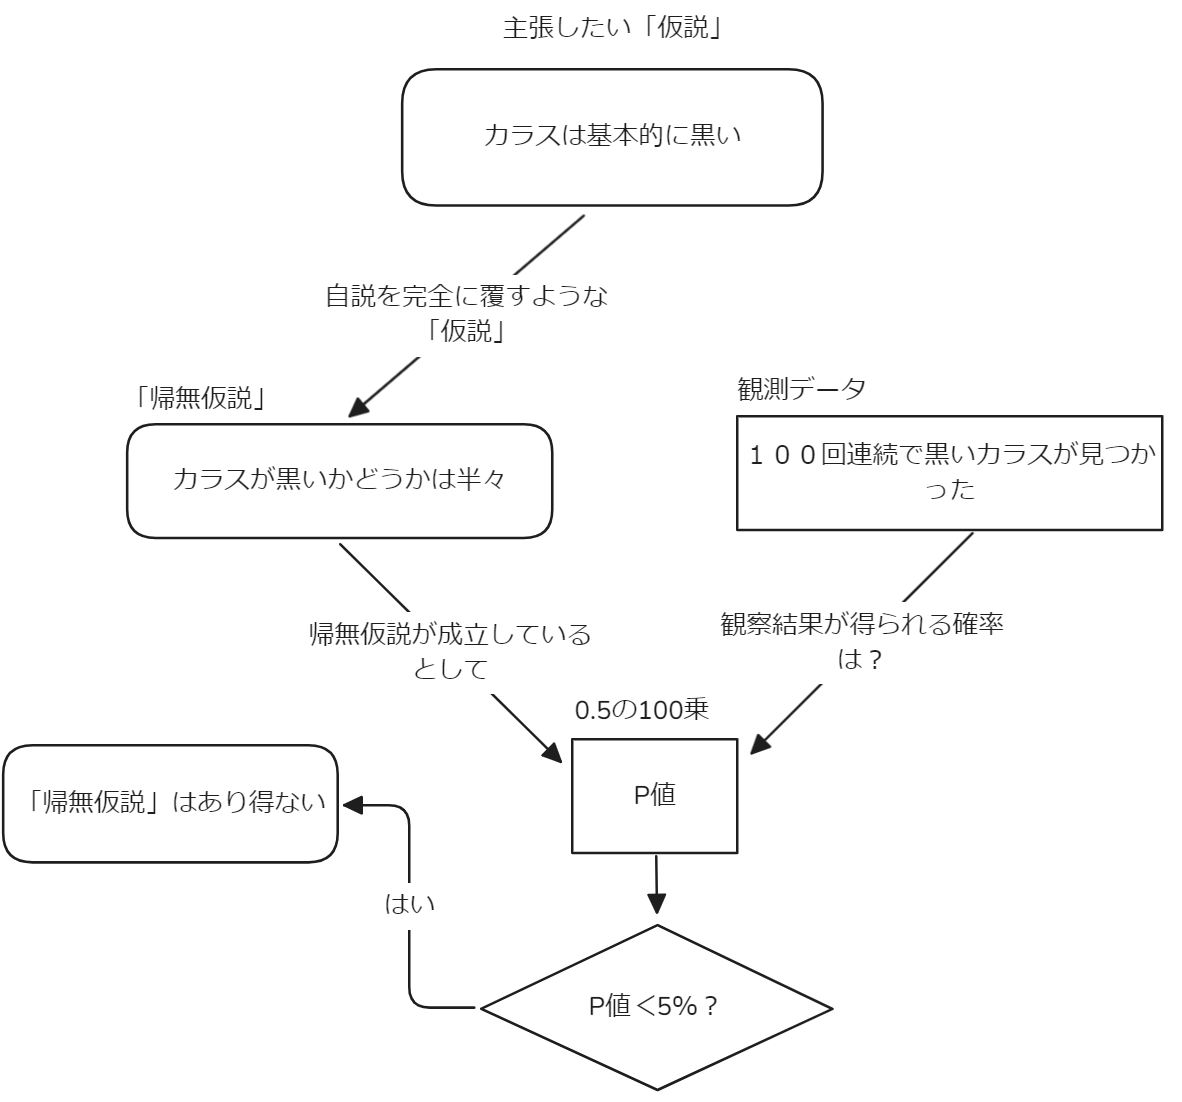

本中では「カラスが黒い確率が50%」という帰無仮説はじめ、いくつかの確率のでの帰無仮説を例にしています。それらを５％を目安に「帰無仮説がありえない」か「帰無仮説を棄却できない」ものに分けている様子をまとめると以下のようになります。

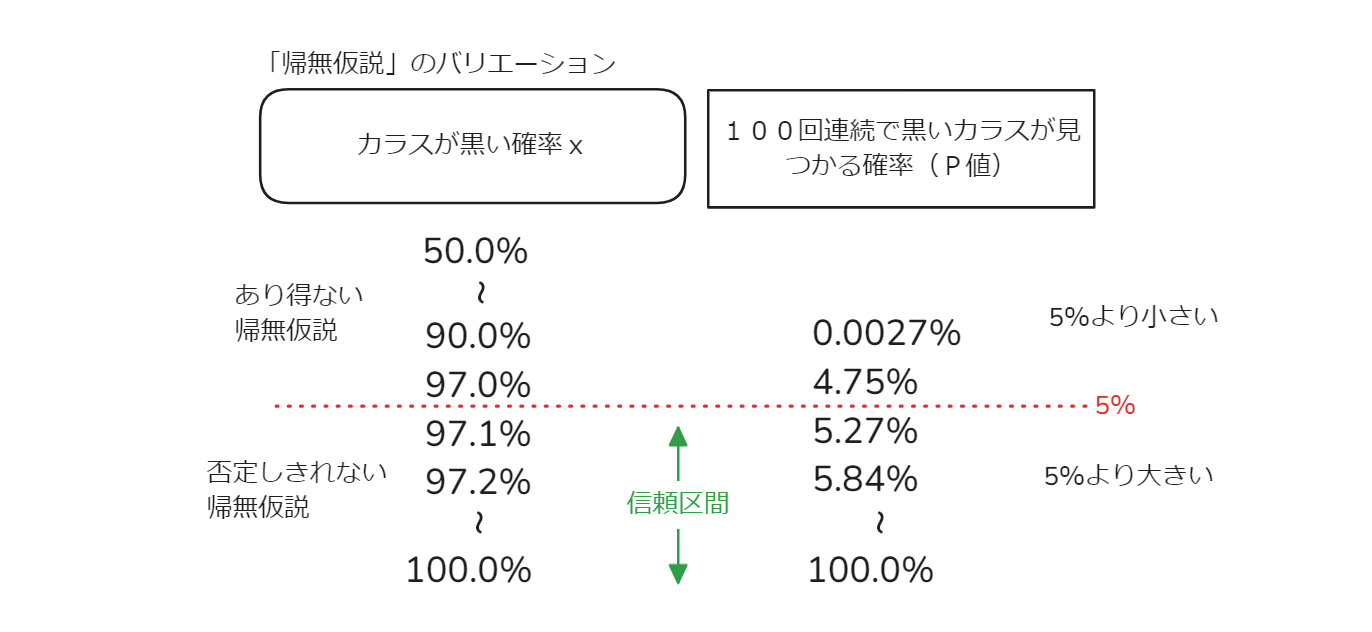

次に、異なる帰無仮説と、対応するP値をプロットします。

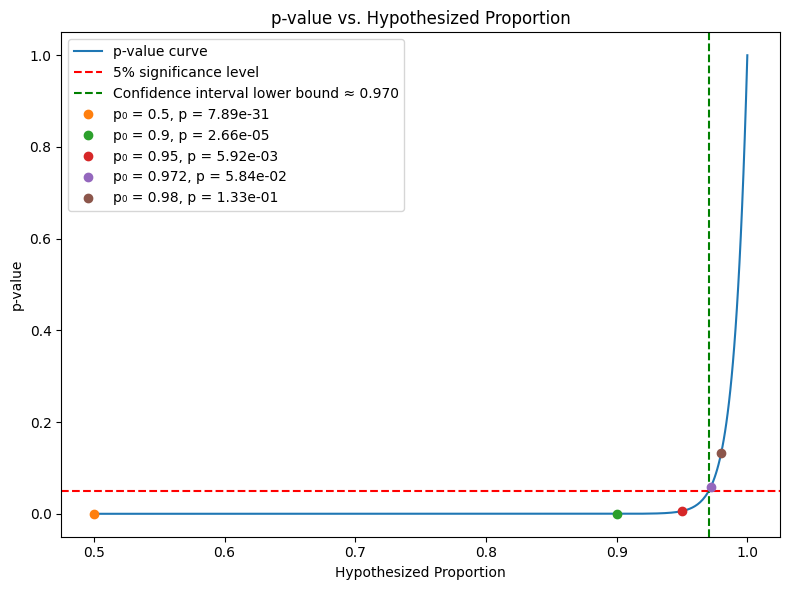

95% Clopper-Pearson Confidence Interval: [0.964, 1.000]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from statsmodels.stats.proportion import proportion_confint

# Observed data: 100 black crows out of 100
n = 100
x = 100

# Define a range of null hypothesized proportions to test
p0_values = np.linspace(0.5, 1.0, 500)

# For a one-tailed test (alternative: proportion > p0),
# the p-value for observing 100 successes is:
#    p_value = P(X >= 100) = binom.sf(99, n, p0) = p0**100.
p_values = np.array([binom.sf(x - 1, n, p0) for p0 in p0_values])

# Find the threshold p0 for which p_value equals 0.05.
# Solve: p0^100 = 0.05  ->  p0 = 0.05^(1/100)
threshold = np.power(0.05, 1/100)

# Plot the p-value curve against the hypothesized proportion
plt.figure(figsize=(8, 6))
plt.plot(p0_values, p_values, label='p-value curve')
plt.axhline(0.05, color='red', linestyle='--', label='5% significance level')
plt.axvline(threshold, color='green', linestyle='--',
            label=f'Confidence interval lower bound ≈ {threshold:.3f}')

# Annotate specific null hypotheses (e.g., 0.50, 0.90, 0.95, 0.972, 0.98)
for p_val in [0.5, 0.9, 0.95, 0.972, 0.98]:
    p_val_p = binom.sf(x - 1, n, p_val)
    plt.plot(p_val, p_val_p, 'o', label=f'p₀ = {p_val}, p = {p_val_p:.2e}')

plt.xlabel('Hypothesized Proportion')
plt.ylabel('p-value')
plt.title('p-value vs. Hypothesized Proportion')
plt.legend()
plt.tight_layout()
plt.show()

# Compute the conventional 95% Clopper-Pearson confidence interval for the true proportion
ci_low, ci_upp = proportion_confint(count=x, nobs=n, alpha=0.05, method='beta')
print(f'95% Clopper-Pearson Confidence Interval: [{ci_low:.3f}, {ci_upp:.3f}]')


上のプロットから分かること。

- 橙の点：「カラスが黒い確率が50%」と仮定して「100羽続けて黒いカラスに遭遇する確率」はほとんどゼロ。
- 緑の点：「カラスが黒い確率が90%」と仮定して「100羽続けて黒いカラスに遭遇する確率」もほとんどゼロ。
- 赤の点：「カラスが黒い確率が95%」と仮定して「100羽続けて黒いカラスに遭遇する確率」もかなりゼロに近い。
- 紫の点：「カラスが黒い確率が97.2%」と仮定して「100羽続けて黒いカラスに遭遇する確率」は5.8%ぐらい（5％を超える）
- 茶の点：「カラスが黒い確率が98.0%」と仮定して「100羽続けて黒いカラスに遭遇する確率」は13.3%ぐらい（100%に向かい始める）

赤い点線がちょうどP値＝5%のところで

- 「左側」はP値が5％より小さい＝＞確率が小さすぎるので、その帰無仮説はあり得ない言える
- 「右側」ではP値が5％より大きい＝＞20回に1回程度かそれ以上起こりうるので、その帰無仮説は棄却的るとは言えない（つまり『あり得る』と言える）





# P値と帰無仮説と信頼区間の関係

「あるP値」がその帰無仮説における信頼区間（受容域）に現れなければ、その帰無仮説は棄却される。
以下のGIFアニメーションでは固定された観測値（P値）と動く帰無仮説の関係から「棄却される帰無仮説 Reject」と「棄却されない帰無仮説 Fail to Reject」として区別できます。

<img src="null_hypothesis.gif" alt="Description of GIF" style="width:500px;"/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import norm

# パラメータ設定
observed_mean = 2.0       # 観測値（赤い垂直線）
sample_mean = 2.0         # データ分布の平均（固定、緑）
standard_error = 0.5      # 標準誤差
alpha = 0.05            # 有意水準

# アニメーション用の変数
null_hypothesis_mean = 0.0  # 初期の帰無仮説の平均（青い分布）
direction = 1             # 方向
speed = 0.02              # 変化速度
min_null = -4.0           # 帰無仮説の移動下限
max_null = 4.0            # 帰無仮説の移動上限

# プロット設定
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlim(-4, 4)
ax.set_ylim(0, 1.0)  # 正規分布の最大値はおおよそ 0.8 程度
ax.set_xlabel("Value")
ax.set_ylabel("Probability Density")
ax.set_title("P-value, Null Hypothesis & 95% CI")

# x軸のデータ点
x = np.linspace(-4, 4, 400)

# 固定のデータ分布（緑）の計算・描画
data_pdf = norm.pdf(x, sample_mean, standard_error)
data_line, = ax.plot(x, data_pdf, color='green', alpha=0.6, label='Data Distribution')

# 観測値（赤）の描画
ax.axvline(observed_mean, color='red', linewidth=2, label='Observed Value')

# 95%信頼区間（灰色）の計算・描画
ci_lower = sample_mean - 1.96 * standard_error
ci_upper = sample_mean + 1.96 * standard_error
ci_height = norm.pdf(sample_mean, sample_mean, standard_error)
ci_rect = plt.Rectangle((ci_lower, 0), ci_upper - ci_lower, ci_height,
                        color='gray', alpha=0.3, label='95% CI')
ax.add_patch(ci_rect)

# null hypothesis 分布（青）の描画（初期は空）
null_line, = ax.plot([], [], color='blue', alpha=0.6, label='Null Hypothesis Distribution')

# p値領域（紫）の描画用オブジェクト（後で fill_between で作成）
pvalue_fill = None

# テキスト表示（左上に各種数値を表示）
text_null = ax.text(-3.8, 0.9, "", fontsize=10)
text_pvalue = ax.text(-3.8, 0.85, "", fontsize=10)
text_decision = ax.text(-3.8, 0.80, "", fontsize=10)
text_ci_status = ax.text(-3.8, 0.75, "", fontsize=10)

ax.legend(loc='upper right')

def init():
    # 初期状態は null hypothesis 分布を空に設定
    null_line.set_data([], [])
    return null_line,

def update(frame):
    global null_hypothesis_mean, direction, pvalue_fill

    # 帰無仮説の平均を更新（bounce 処理）
    null_hypothesis_mean += direction * speed
    if null_hypothesis_mean > max_null:
        null_hypothesis_mean = max_null
        direction *= -1
    elif null_hypothesis_mean < min_null:
        null_hypothesis_mean = min_null
        direction *= -1

    # null hypothesis 分布（青）の計算
    null_pdf = norm.pdf(x, null_hypothesis_mean, standard_error)
    null_line.set_data(x, null_pdf)

    # 前回の p値領域があれば削除
    if pvalue_fill is not None:
        pvalue_fill.remove()

    # 観測値より右側の領域を、null hypothesis 分布から塗る（紫色）
    x_fill = np.linspace(observed_mean, 4, 200)
    y_fill = norm.pdf(x_fill, null_hypothesis_mean, standard_error)
    pvalue_fill = ax.fill_between(x_fill, y_fill, color='purple', alpha=0.3)

    # P値の計算（ここでは右側片側検定）
    z = (observed_mean - null_hypothesis_mean) / standard_error
    p_val = 1 - norm.cdf(z)

    # テキストの更新
    text_null.set_text(f"Null Hypothesis Mean: {null_hypothesis_mean:.2f}")
    text_pvalue.set_text(f"P-value: {p_val:.4f}")
    if p_val < alpha:
        text_decision.set_text(f"Decision: Reject H₀ (P < {alpha})")
    else:
        text_decision.set_text(f"Decision: Fail to Reject H₀ (P ≥ {alpha})")
    if ci_lower <= null_hypothesis_mean <= ci_upper:
        text_ci_status.set_text("Null hypothesis within 95% CI")
    else:
        text_ci_status.set_text("Null hypothesis outside 95% CI")
    
    return null_line, pvalue_fill, text_null, text_pvalue, text_decision, text_ci_status

# アニメーション作成（300フレーム、50ミリ秒間隔）
ani = animation.FuncAnimation(fig, update, frames=300, init_func=init, interval=50, blit=False)

# GIFとして保存（PillowWriter を使用）
gif_filename = "pvalue_animation.gif"
writer = animation.PillowWriter(fps=20)
ani.save(gif_filename, writer=writer)
plt.close()

print(f"Animation saved as {gif_filename}")


Animation saved as pvalue_animation.gif
